In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    os.environ['CUDA_VISIBLE_DEVICES'] = \
        os.environ['CUDA_VISIBLE_DEVICES'].split(',')[1]
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


4,5
5
Sun Nov 19 21:23:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   43C    P0   224W / 300W |    551MiB / 32510MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| 

In [ ]:
import os
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)

# model_name = 'llama-7b'; encode_fn_type = 'sft'; md = 'llama7b'
# model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'llama7b'
model_name = 'mistral-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'mistral7b'
# model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'; md = 'mpnet'
# model_name = 'bge-large-en-v1.5'; encode_fn_type = 'input'; md = 'bge'

# nc_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
nc_list = [100, 500, 1000]
nc_list = [100, 200, 300, 400, 500, 600]

sort_by_list = [
    f'semdedup_cl=kmeansfaisscd_md={md}_dist=cd_emb={emb}_nc={nc}'
    for nc in nc_list
    for emb in ['text+embedding', 'grad+rp+loraB'] # 'grad+rp+loraB' 
]

# sort_by_list = [
#     'random_s=0', 'random_s=1', 'random_s=2',
#     'log_prob', 'logit_margin', 'el2n_agg=mean',
#     'grad_loraB_l2n', 'numtoks'
# ]
# sort_by_list += [
# #     'kmeansl2_emb=grad+rp+loraB_nc=300',
# #     'kmeansl2_emb=grad+rp+loraB_nc=1000',
#     'kmeansl2_emb=grad+rp+loraB_nc=3000',
# #     'kmeansl2_emb=text+embedding_nc=300',
#     'kmeansl2_emb=text+embedding_nc=1000',
# #     'kmeansl2_emb=text+embedding_nc=3000',
# ]
# sort_by_list = ['numtoks']

# sort_by_list += [
#     'dppmap_emb=grad+rp+loraB_k=Kcos', 
#     'dppmap_emb=text+embedding_k=Kcos', 
#     'dppmap_emb=grad+rp+loraB_k=Kcosp', 
#     'dppmap_emb=text+embedding_k=Kcosp',
#     'dppmap_emb=grad+rp+loraB_k=Kcos1np', 
#     'dppmap_emb=text+embedding_k=Kcos1np',
# ]
# dataset_list = ['lima']
# dataset_list = ['flan2022_1m']
# dataset_list = ['tulu_v1_mix']
# dataset_list = ['ultrachat']
dataset_list = ['ultrachat15']
# dataset_list = ['wizardlm']
# dataset_list = ['sharegpt']


# sort_by_list = [
#  'log_prob',
#  'el2n_agg=mean',
#  'el2n_agg=l2n',
#  'logit_margin',
# ]
# if 'lora' in model_name:
#     sort_by_list += ['grad_loraB_l2n']
# else:
#     sort_by_list += ['grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',]
# sort_by_list = ['kmeansl2_emb=grad+rp+loraB_nc=30',
#                 'kmeansl2_emb=text+embedding_nc=30']
# dataset_list = ['lima']


# model_name = 'pythia-1b-deduped'
# model_name = 'pythia-1b-deduped+lora:r=256:a=256'
# dataset_list = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1']
# # sort_by_list = ['random_s=0', 
# #                 'log_prob', 'logit_margin', 'el2n_agg=mean', 'el2n_agg=l2n', 
# #                 'kmeansl2_nc=3000', 'kmeanscd_nc=3000',
# #                 'grad_loraB_l2n',
# #                 'grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',
# #                ]
# sort_by_list = ['grad_loraB_l2n']

from note_pruning_analysis import data_inds_dir

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    save_dir = os.path.join(data_inds_dir, model_name, dataset)
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --model_name {model_name} \
        --encode_fn_type {encode_fn_type} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=256, # 128
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


In [ ]:
with open('note_pruning_run_cmds.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES']
    devices = 1
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [ ]:
# !bash note_pruning_run_cmds.sh
!

### Generate curriculum from pre-computed scores (via `note_pruning.py`)

In [ ]:
import itertools
from note_curriculum import (
    get_curriculum_scores,
    get_curriculum,
    generate_curriculum,
    generate_curriculum_forall_scoring_fn,
    scores_path_to_attrs,
    np_random_choice_maximize_noreplacement,
    plt_curriculum,
)
from note_pruning_analysis import assets_dir

# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000
# model_name = 'llama-7b'; dataset = 'sharegpt'; M = 150_000

## mistral+ultrachat
# model_name = 'mistral-7b'; dataset = 'ultrachat200k'; M = 50_000
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000

## semdedup
# model_name = 'llama-7b'; dataset = 'wizardlm'; M = 100_000
# model_name = 'all-mpnet-base-v2'; dataset = 'wizardlm'; M = 100_000
# model_name = 'bge-large-en-v1.5'; dataset = 'wizardlm'; M = 100_000
# model_name = 'all-mpnet-base-v2'; dataset = 'ultrachat15'; M = 100_000
model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000


pacing_fn_list = [
#     f'prune_size={M}_ep=1',
    f'prune_size={M}_ep=2',
#     f'prune_size={M}_ep=3',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.05',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
]

output_list = generate_curriculum_forall_scoring_fn(
    model_name, dataset, pacing_fn_list, verbose=False)

In [ ]:
1

In [ ]:
import re
import numpy as np
from note_curriculum import get_curriculum_scores, generate_curriculum, plt_curriculum
import glob
import matplotlib.pyplot as plt

model_name = 'mistral-7b'; dataset = 'ultrachat'; M =  50_000
# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000


paths = glob.glob('curriculum/*/*/*/scores.pkl')
paths = [x for x in paths if 'llama' in x and 'tulu_v1_mix' in x and 'log_prob_neg' in x]
path = paths[0]

verbose = True
print(path)
pacing_fn = f'prune_size={M}_ep=3'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.1'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.2'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.3'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.2_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'

pacing_fn_list = [
    f'prune_size={M}_ep=3',
    f'singlestep_size={M}_startingfrac=0.05',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.2',
#     f'singlestep_size={M}_startingfrac=0.3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=3',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.25'
]



nrows = len(pacing_fn_list)
fig, axs = plt.subplots(nrows, 3, figsize=(15,3*nrows), sharey=False, gridspec_kw={'width_ratios': [2,.5,.5]})

for i, pacing_fn in enumerate(pacing_fn_list):

    plt_kwargs = generate_curriculum(path, pacing_fn, verbose=True, save_output=False)
    output = plt_kwargs.pop('output')
    plt_kwargs.update({'fig': fig, 'axs': axs[i]})
    plt_curriculum(**plt_kwargs)

fig.tight_layout()



save_plt = 0
if save_plt:
    model_name, dataset, scoring_fn = output['model_name'], output['dataset'], output['scoring_fn']
    save_path = os.path.join(
        assets_dir, f'note_curriculum_{model_name}:{dataset}:{scoring_fn}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)



### main code

In [2]:
import os
import sys
import numpy as np
import time
import re
import random
import json
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers
import pandas as pd

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    sort_dpp_map,
    save_prune_results,
    sort_dpp_map_memefficient,
)
from note_pruning_analysis import get_lm_output

In [3]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
dataset = 'flan2022_1m'
dataset = 'tulu_v1_mix'
dataset = 'lima'
dataset = 'ultrachat200k'
dataset = 'ultrachat15'
dataset = 'wizardlm'

# sort_by = 'random_s=0'
# sort_by = 'kmeansl2_nc=3000'
# sort_by = 'kmeanscd_nc=3000'
# sort_by = 'log_prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'
# sort_by = 'el2n'
# sort_by = 'grad_norm'
# sort_by = 'kmeansl2_emb=grad+rp+loraB_nc=3000'
# sort_by = 'kmeansl2_emb=text+embedding_nc=3000'
sort_by = 'dppmap_emb=text+embedding_k=Kcos'
# sort_by = 'logit_margin'
# rhov1: mistral-7b base-tuned(ultrachat200k_beforesplitlongconv)
# sort_by = 'rhov1'
# sort_by = 'numtoks'

# used for generating model output.
# model_name = 'llama-7b'; encode_fn_type = 'sft'
# model_name = 'llama-7b_ft=hmv1'; encode_fn_type = 'sft'
# model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'
# model_name = 'mistral-7b+lora:r=256:a=256'; encode_fn_type = 'sft'
model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'
# model_name = 'bge-large-en-v1.5'; encode_fn_type = 'input'

# model_name = 'mistral-7b+lora:r=256:a=256__rho__mistral-7b-ultrachat200k-v1+lora:r=256:a=256'


save_dir = f"data_inds/"
save_dir = os.path.join(save_dir, '' if encode_fn_type=='sft' else encode_fn_type, model_name, dataset)
os.makedirs(save_dir, exist_ok=True) 

print(dataset, model_name, sort_by)
print(save_dir)

wizardlm all-mpnet-base-v2 dppmap_emb=text+embedding_k=Kcos
data_inds/input/all-mpnet-base-v2/wizardlm


In [ ]:
d = get_lm_output(dataset, model_name, encode_fn_type=encode_fn_type, return_text_embedding=True)
if test_run:
    d = {k: v[:1000] for k, v in d.items()}
    
# some entries are nan, impute with mean value.
N = d['text_embedding'].shape[0]
print(N)

In [194]:

from scipy.spatial.distance import squareform, pdist, cdist

def sq_distances(X,Y=None):
    """ Returns K where Kij = ||X_i - Y_j||^2 """
    assert(X.ndim==2)
    # Compute pairwise distance matrix. 
    #     Don't use explicit loops, but the above scipy functions
    # if X=Y, use more efficient pdist call which exploits symmetry
    if Y is None:
        sq_dists = squareform(pdist(X, metric='sqeuclidean'))
    else:
        assert(Y.ndim==2)
        assert(X.shape[1]==Y.shape[1])
        sq_dists = cdist(X, Y, metric='sqeuclidean')

    return sq_dists


def gauss_kernel(X, Y=None, sigma=1.0):
    """ Computes the standard Gaussian kernel k(x,y)=exp(- ||x-y||**2 / (2 * sigma**2))
        Returns the kernel matrix
    """
    sq_dists = sq_distances(X,Y)
    K = np.exp(-sq_dists / (2 * sigma**2))
    return K


def eip_kernel(X, Y, gamma=1.0):
    """Computes exponentiated inner product kernel k(x,y)=exp(γ·x^Ty) """
    S = X@Y.T
    S = (S+1)/2 # ensure similarity >=0 (avoid the case where S<0 and yields a larger K)
    K = np.exp(gamma*S)
    return K


def linear_kernel(X, Y):
    return np.dot(X, Y.T)

7.061573548128308e-13 1.0000000000000002
[[7.3890561  4.91878541 5.82116361]
 [4.91878541 7.3890561  2.53385573]
 [5.82116361 2.53385573 7.3890561 ]]


(<Figure size 400x400 with 2 Axes>, <Axes: title={'center': 'kernel L'}>)

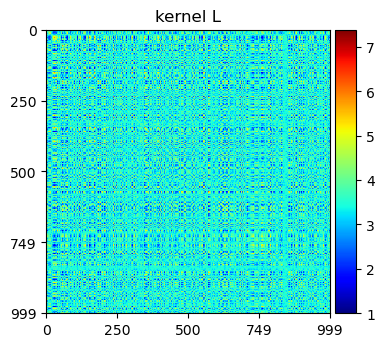

In [259]:
import scipy
from numpy.random import RandomState
from scipy.linalg import qr
from dppy.finite_dpps import FiniteDPP

from rosemary import plt_kernel_matrix_one
import matplotlib.pyplot as plt


import sys
sys.path.insert(0, "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/fast-map-dpp")
from dpp import dpp


def get_subset(L, subset_type, k):
    rng = RandomState(0)
    if subset_type == 'random':
        np.random.seed(0)
        inds = np.random.choice(len(L), k).tolist()
    elif subset_type == 'dpp_exactk':
        DPP = FiniteDPP(kernel_type='likelihood', projection=False,  L=L)
        inds = DPP.sample_exact_k_dpp(size=k, random_state=rng)
    elif subset_type == 'dpp_sample':
        DPP = FiniteDPP(kernel_type='likelihood', projection=False,  L=L)
        inds = DPP.sample_exact(mode='Chol', random_state=rng)
    elif subset_type == 'dppmap':
        inds = dpp(L, max_length=len(L))
    else:
        raise ValueError(f'subset_type={subset_type} not implemented.')
    return inds


def get_L(X, dist, **kwargs):
    if dist == 'cd':
        L = (X@X.T+1)/2
    if dist == 'eip':
        L = eip_kernel(X, X, **kwargs)
    elif dist == 'l2':
        L = gauss_kernel(X, **kwargs)
    else:
        raise ValueError(f'X ({X.shape}) with dist={dist} cannot compute L.')
    return L


def plt_subsets(Is, X):
    naxs = len(Is)
    fig, axs = plt.subplots(1,naxs,figsize=(4*naxs,4))
    for i in range(naxs):
        ax = axs[i]
        subset_type, inds = list(Is.items())[i]
        ax.scatter(X[:,0], X[:,1], alpha=.5)
        ax.scatter(X[inds,0], X[inds,1], label=subset_type)
        ax.set_title(f'{subset_type} (M={len(inds)})', fontsize=15)
    fig.tight_layout()
    return fig, axs

N, d = 1000, 2
dist = 'eip'; get_L_kwargs = {'gamma': .5}

np.random.seed(0)
X = np.random.rand(N, d)-.5
if dist != 'l2':
    X = X / np.linalg.norm(X, axis=-1, keepdims=True)
    
L - get_L(X, dist, **get_L_kwargs)
print(L[:3,:3])

fig, ax = plt.subplots(1,1,figsize=(4,4))
plt_kernel_matrix_one(fig, ax, L, title='kernel L')

In [252]:
k = 100

Is = {}
for subset_type in ['random', 'dpp_sample', 'dppmap']:#  'dpp_exactk', 
    Is[subset_type] = get_subset(L, subset_type, k)

K (correlation) kernel computed via:
- eigendecomposition of L
- eig_K = eig_L/(1+eig_L)
- U diag(eig_K) U.T
4.4920217660158075e-12


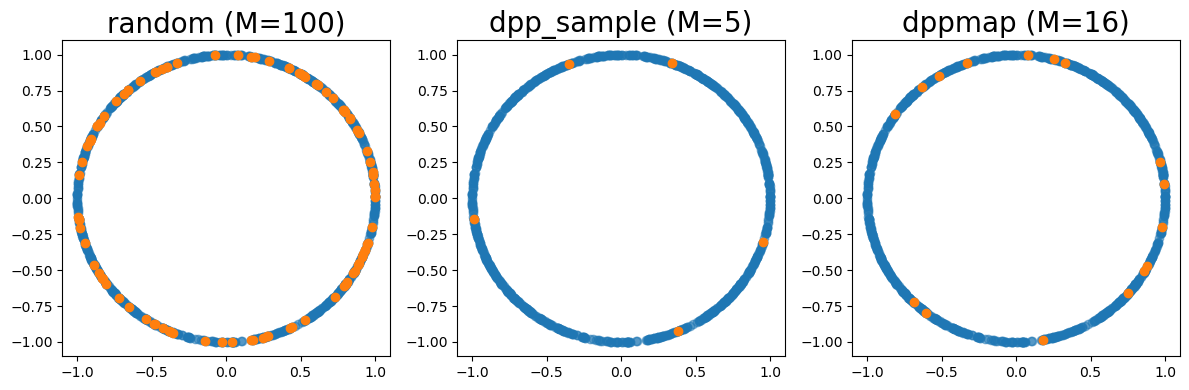

In [254]:
fig, axs = plt_subsets(Is, X)

7.061573548128308e-13 1.0000000000000002
4.555180213903599e-11
7.061573548128308e-13 1.0000000000000002
4.3453150572318106e-12
7.061573548128308e-13 1.0000000000000002
3.171732576993122e-11
7.061573548128308e-13 1.0000000000000002
6.109569014682924e-11


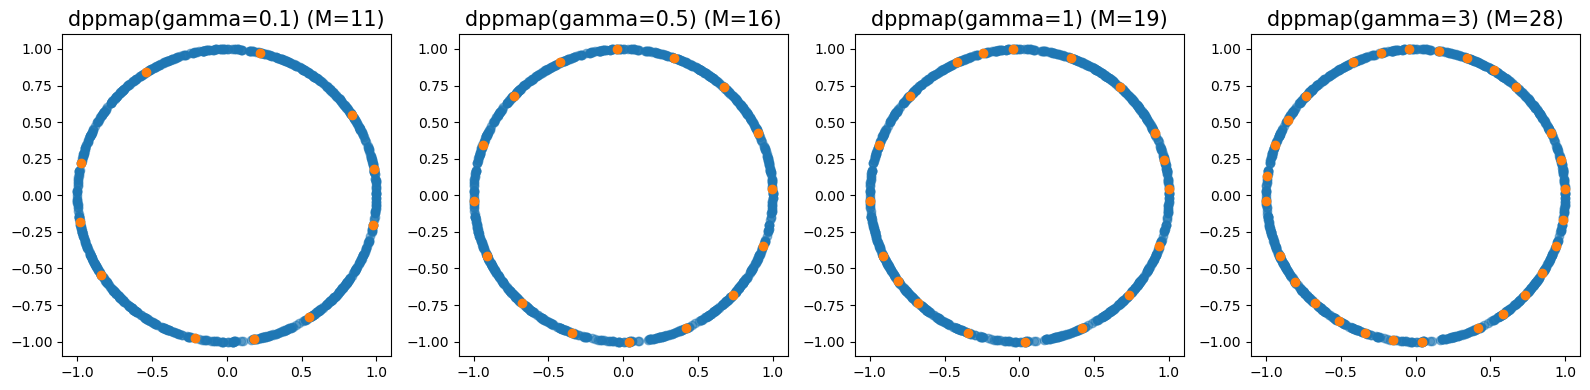

In [261]:
np.random.seed(0)
X = np.random.rand(N, d)-.5
if dist != 'l2':
    X = X / np.linalg.norm(X, axis=-1, keepdims=True)

Is = {}
subset_type = 'dppmap'
k = 100
for gamma in [.1, .5, 1, 3]:
    L = get_L(X, dist, gamma=gamma)
    Is[subset_type+f'(gamma={gamma})'] = get_subset(L, subset_type, k)


fig, axs = plt_subsets(Is, X)

In [ ]:
sort_by = 'dppmap_emb=text+embedding_k=Kcos'
# 'semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200',

sort_by = 'dppmap_cl=kmeansfaisscd_md=mpnet_emb=text+embedding_nc=200'


match = re.search(r'k=(\w+)', sort_by)
kernel_type = match.group(1) if match else None
match = re.search(r'emb=([^_]+)', sort_by)
embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
    raise ValueError(f'Invalid embed_type = {embed_type}')
md = re.search(r'md=([^_]+)', sort_by).group(1)
if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
   (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
   (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
   (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')):
    raise ValueError(f'md={md} does not match with model_name={model_name}')
print(kernel_type, embed_type)


In [ ]:

match = re.search(r'k=(\w+)', sort_by)
kernel_type = match.group(1) if match else None
match = re.search(r'emb=([^_]+)', sort_by)
embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
    raise ValueError(f'Invalid embed_type = {embed_type}')
    md = re.search(r'md=([^_]+)', sort_by).group(1)
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
       (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
       (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
       (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
emb = d[embed_type]
log_prob = d['log_prob']
# inds = sort_dpp_map_memefficient(emb, log_prob, kernel_type=kernel_type, torch_compile=False)


In [ ]:
## the copy in `note_pruning.py` is most up to date

pkl_extra = {}
inds = None


t0 = time.time()
if any(sort_by.startswith(x) for x in [
        'log_prob', 
        'el2n',  # el2n_agg={l2n|mean}
        'logit_margin', 
        'grad',  # grad_{loraB|qkv|all|last}_l2n
    ]):
    if sort_by not in d:
        print(f'sort_by={sort_by} not in model output: ({dataset}, {model_name})')
    S = np.nan_to_num(d[sort_by], nan=np.nanmean(d[sort_by])).squeeze()
elif sort_by.startswith('random'):
    match = re.search(r's=(\d+)', sort_by)
    seed = int(match.group(1))
    np.random.seed(seed)
    S = np.random.rand(N)
    assert(S.shape == np.unique(S).shape)
if sort_by.startswith('kmeans'):
    dist_fn = 'l2' if sort_by.startswith('kmeansl2') else 'cd'
    match = re.search(r'nc=(\d+)', sort_by)
    n_clusters = int(match.group(1)) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    print(f'Running kmeans(n_clusters={n_clusters}) {{ {embed_type} }} to compute {"euclidean" if dist_fn == "l2" else "cosine"} distance to cluster centers.')
    S, kms = sort_kmeans_dist_to_cluster_centers(emb, n_clusters, dist_fn=dist_fn)
    pkl_extra['kmeans'] = kms
elif sort_by.startswith('semdedup'):
    import note_pruning_clustering
    md = re.search(r'md=([^_]+)', sort_by).group(1)
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
       (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
       (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
       (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
    clustering_fn = sort_by.split('semdedup_')[-1]
    match = re.search(r'dist=([^_]+)', sort_by)
    dist = match.group(1)
    assert(dist in ['cd', 'l2'])
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1))
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    save_dir_clustering = os.path.join('clustering', encode_fn_type, model_name, dataset, clustering_fn)
    os.makedirs(save_dir_clustering, exist_ok=True)
    # normalize embeddings to unit norm if the model that generated the embeddings does the 
    # same, e.g., mpnet, bge, or if using spherical kmeans clustering.
    if any(x in model_name for x in ['mpnet', 'bge']) or 'kmeansfaisscd' in clustering_fn:
        normalize_embeddings = True
    else:
        normalize_embeddings = False
    kwargs = {
        'model_name': model_name,
        'dataset': dataset,
        'encode_fn_type': encode_fn_type,
        'clustering_fn': clustering_fn,
        'embed_type': embed_type,
        'normalize_embeddings': normalize_embeddings,
        'first_N': None,
        'save_dir': save_dir_clustering,
    }
    print(f'Calling note_pruning_clustering.main with kwargs={json.dumps(kwargs, indent=4)}')
    X, Y, C = note_pruning_clustering.main(**kwargs)
    print('Apply SemDeDup to discard duplicates.')
    S = note_pruning_clustering.semdedup(X, Y, dist=dist, device='cuda')
elif sort_by.startswith('dpp'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    log_prob = d['log_prob']
    inds = sort_dpp_map_memefficient(emb, log_prob, kernel_type=kernel_type, torch_compile=False)
elif sort_by.startswith('rho'):
    if sort_by == 'rhov1':
        model_names = ['mistral-7b+lora:r=256:a=256',
                       'mistral-7b-ultrachat200k-v1+lora:r=256:a=256']
        assert(model_name == model_names[0])
    else:
        raise ValueError(f'sort_by={sort_by} not implemented.')
    assert(len(model_names) == 2)
    ds = []
    for x in model_names:
        ds.append(get_lm_output(dataset, x, return_text_embedding=False, fill_nan=False))
    ks = [set(d.keys()) for d in ds]
    ks = ks[0] & ks[1]
    for k in ks:
        S0 = ds[0][k]
        S1 = ds[1][k]
        # handle nan entries properly.
        nan_mask = np.logical_or(np.isnan(S0), np.isnan(S1))
        S = np.subtract(S0, S1)
        S[nan_mask] = np.nan
        S = S.squeeze()
        save_prune_results(save_dir, None, S, {}, f'{sort_by}_{k}', model_name, dataset)
elif sort_by.startswith('numtoks'):
    from transformers import AutoTokenizer
    from note_pruning_analysis import get_dataset_token_lengths
    if 'llama' in model_name or 'mistral' in model_name:
        tokenizer = AutoTokenizer.from_pretrained(
            '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/results/baselines/huggyllama/llama-7b',
            use_fast=False, # use_fast sometimes cause error.
        )
    else:
        raise ValueError('Need to supply appropriate tokenizer to count token lengths,')
    d = get_dataset_token_lengths(dataset, tokenizer)

    d['total_len'] = d['input_len'] + d['output_len']
    for k in ['input', 'output', 'total']:
        S = d[f'{k}_len']
        save_prune_results(save_dir, None, S, {}, f'{sort_by}_{k}', model_name, dataset)

        
t1 = time.time()
print(f'Rank datapoints with {sort_by} took {t1-t0:.2f} seconds.')

# from note_pruning import save_prune_results
if not any(sort_by.startswith(x) for x in ['rho', 'numtoks']):
    save_prune_results(save_dir, inds, S, pkl_extra, sort_by, model_name, dataset)

In [ ]:
k = 'log_prob'
t = 100
S0 = ds[0][k].squeeze()[::t]
S1 = ds[1][k].squeeze()[::t]
# log prob neg
S0, S1 = -S0, -S1
# S = S0-S1

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(20, 3))
xs = np.arange(len(S0))
inds_sorted = np.argsort(S0)
ax.plot(xs, S0[inds_sorted], label='S_base')
ax.plot(xs, S1[inds_sorted], label='S_train')
ax.plot(xs, S[inds_sorted], label='S_base-S_train')
ax.legend()
ax.set_title(f'{model_name}  {dataset}  sort_by={sort_by}', fontsize=20)


fig, ax = plt.subplots(1,1,figsize=(20, 3))
xs = np.arange(len(S0))
inds_sorted = np.argsort(S1)
ax.plot(xs, S0[inds_sorted], label='S_base')
ax.plot(xs, S1[inds_sorted], label='S_train')
ax.plot(xs, S[inds_sorted], label='S_base-S_train')
ax.legend()


fig, ax = plt.subplots(1,1,figsize=(20, 3))
xs = np.arange(len(S0))
inds_sorted = np.argsort(S)
ax.plot(xs, S0[inds_sorted], label='S_base')
ax.plot(xs, S1[inds_sorted], label='S_train')
ax.plot(xs, S[inds_sorted], label='S_base-S_train')
ax.legend()